In [1]:
# Import libraries
import pandas as pd
import sys
import os
import warnings
import matplotlib.pyplot as plt

from src.data_preparation_automl_regression import *
from pycaret.regression import *

# Set options for displaying dataframes and figures
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None

# Forecasting with PyCaret Regression

#### Load Data

In [2]:
# Load data
df_data = load_processed_data()

#### Perform train and test split

In [3]:
# Check min and max date and length of dataframe
give_dataframe_information(df_data)

Minimum date: 2014-02-02 00:00:00
Maximum date: 2016-07-31 00:00:00
Length of the DataFrame: 795


The same as using PyCaret for Time-Series we want the testset to have length of 60. This means the trainset consists of 60 days.

In [7]:
# Go back 60 days
split_date = df_data.index.max() - pd.DateOffset(days=60)

In [9]:
# Perform the test and train split
df_train, df_test = train_and_test_split(df_data, split_date)

#### Create Experiment

In [12]:
# Setup for regression experiment
reg = setup(data = df_train,
            test_data = df_test,
            target = 'Sales_Qty',
            numeric_features = ['Year','Quarter','Month','Day_of_Week','lag_1_day','lag_7_days','lag_30_days'], 
            transformation = True,
            transform_target = True,
            fold_strategy = "timeseries",
            fold = 5,
            session_id = 42,
            data_split_shuffle = False,
            fold_shuffle = False
            )

,Description,Value
0,Session id,42
1,Target,Sales_Qty
2,Target type,Regression
3,Original data shape,"(795, 8)"
4,Transformed data shape,"(795, 8)"
5,Transformed train set shape,"(735, 8)"
6,Transformed test set shape,"(60, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


#### Compare the models based on RMSE and other obtained metrics

In [16]:
reg.compare_models(sort = 'RMSE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,2.5201,13.1030,3.2148,0.2534,0.3670,0.5436,0.0200
lr,Linear Regression,3.0128,14.9962,3.8321,0.3280,0.4410,0.6479,0.5940
omp,Orthogonal Matching Pursuit,2.9860,15.0235,3.8375,0.3243,0.4290,0.6039,0.0160
en,Elastic Net,3.0034,15.0708,3.8406,0.3252,0.4360,0.6320,0.0140
lasso,Lasso Regression,3.0157,15.2174,3.8619,0.3168,0.4365,0.6327,0.3480
llar,Lasso Least Angle Regression,3.0157,15.2174,3.8619,0.3168,0.4365,0.6327,0.0220
ridge,Ridge Regression,3.0481,15.3535,3.8778,0.3122,0.4403,0.6375,0.0180
br,Bayesian Ridge,3.0414,15.3669,3.8803,0.3110,0.4430,0.6512,0.0140
et,Extra Trees Regressor,3.0993,16.7518,4.0112,0.2742,0.4497,0.6499,0.0620
rf,Random Forest Regressor,3.1364,16.7318,4.0372,0.2578,0.4462,0.6511,0.0680


HuberRegressor()

#### Huber Regression

In [18]:
# Create the huber regression model
huber = reg.create_model("huber")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.5684,11.9811,3.4614,0.3708,0.4833,0.7711
1,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
2,3.5335,18.0284,4.2460,0.1851,0.5642,0.9316
3,3.7217,21.9499,4.6851,0.3915,0.4900,0.6931
4,2.7768,13.5556,3.6818,0.3198,0.2973,0.3223
Mean,2.5201,13.1030,3.2148,0.2534,0.3670,0.5436
Std,1.3334,7.4253,1.6637,0.1457,0.2035,0.3374


In [20]:
# Tune the model
tuned_huber = reg.tune_model(huber)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:01:41
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Huber Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.5641,11.9388,3.4553,0.3730,0.4805,0.7610
1,-0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000
2,3.5372,18.0543,4.2490,0.1840,0.5644,0.9313
3,3.7213,21.9575,4.6859,0.3913,0.4899,0.6926
4,2.7755,13.5505,3.6811,0.3200,0.2974,0.3222
Mean,2.5196,13.1002,3.2143,0.2537,0.3664,0.5414
Std,1.3338,7.4319,1.6640,0.1462,0.2032,0.3359


Fitting 5 folds for each of 10 candidates, totalling 50 fits


#### Diagnostics

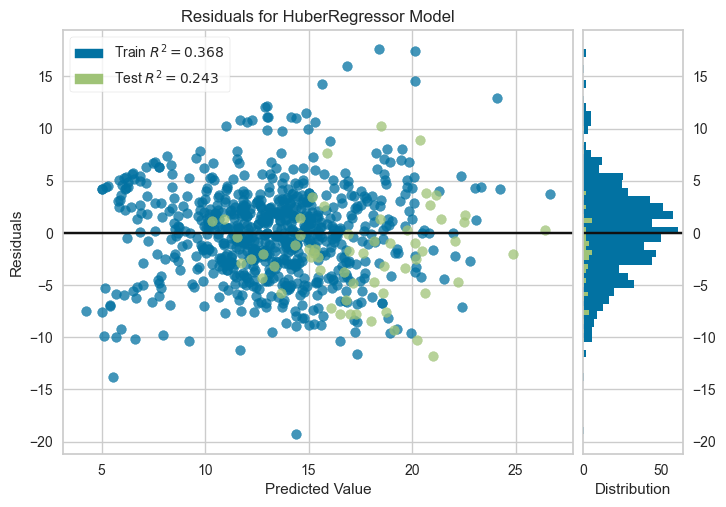

In [26]:
# Plot the Residuals for the model
plot_model(huber)

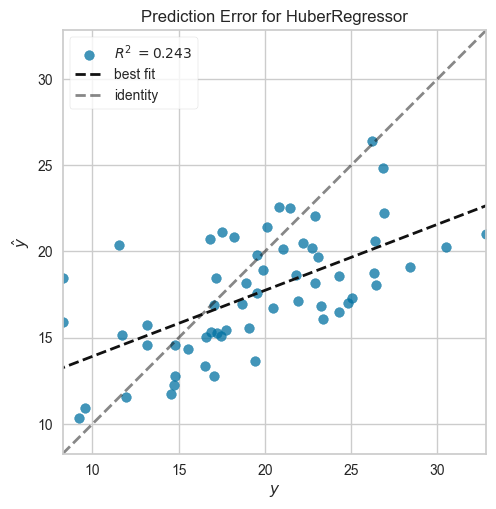

In [27]:
# Plot Prediction Error
plot_model(huber, plot = 'error')

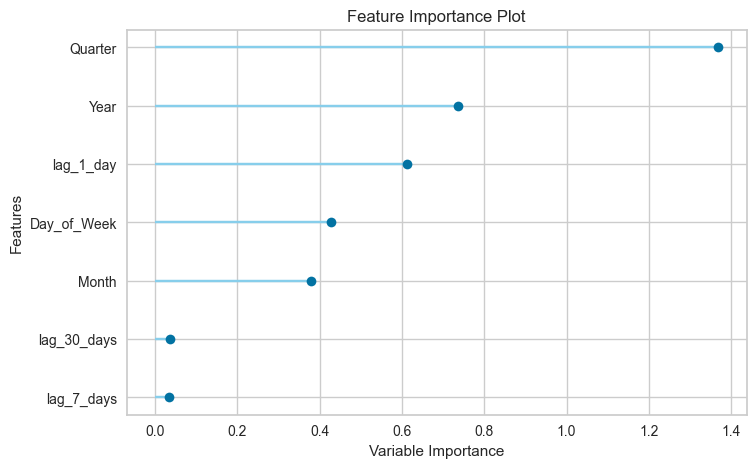

In [28]:
# Plot Feature Importance
plot_model(huber, plot='feature')

#### In-Sample Forecast

In [31]:
# Make predictions on the training data
train_predictions = reg.predict_model(huber, data=df_train)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,41.2167,3477.6798,58.9719,0.3150,0.8685,2.1184


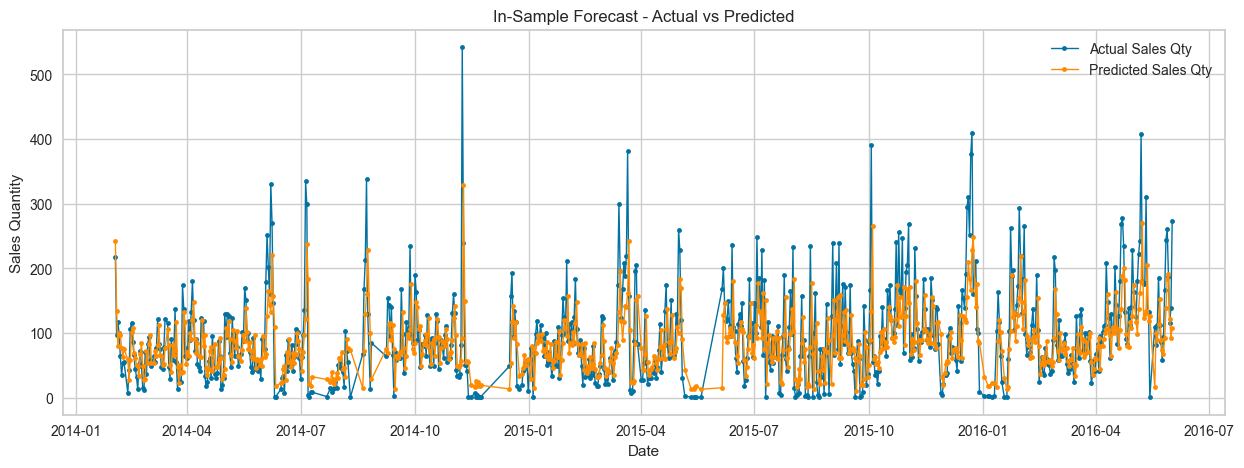

In [48]:
# Plot in sample forecast
plt.figure(figsize=(15, 5))
plt.plot(df_train.index, df_train['Sales_Qty'], label='Actual Sales Qty', marker=".", linewidth=1)
plt.plot(df_train.index, train_predictions['prediction_label'], label='Predicted Sales Qty', color='darkorange', marker=".", linewidth=1)
plt.title('In-Sample Forecast - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.show()

#### Out of Sample Forecast

In [ ]:
# Retrain the model on the entire dataset
final_huber = reg.finalize_model(huber)

In [ ]:
# Make predictions on the testing dataset
test_predictions = reg.predict_model(final_huber, data=df_test)

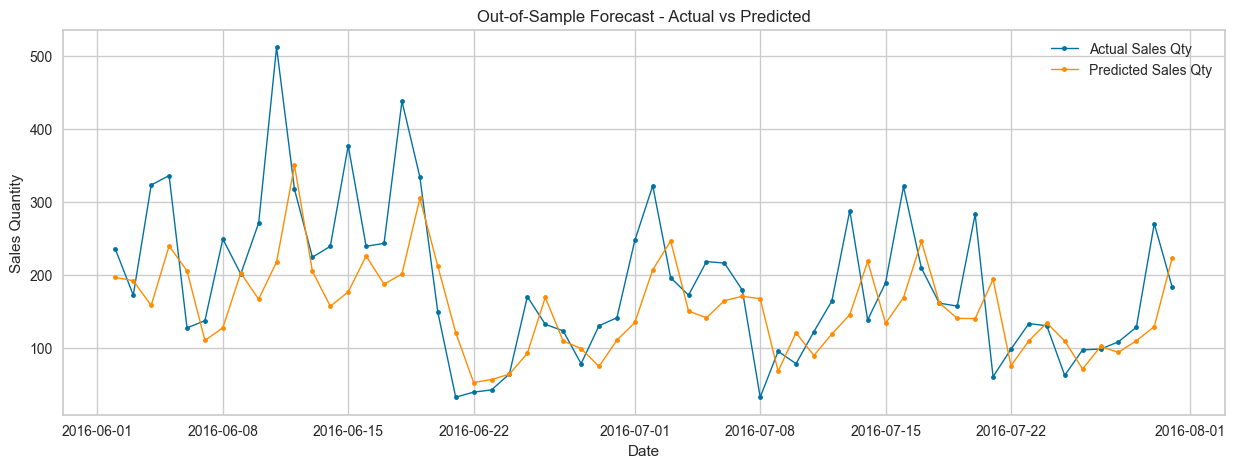

In [49]:
# Plot out of sample forecast
plt.figure(figsize=(15, 5))
plt.plot(df_test.index, df_test['Sales_Qty'], label='Actual Sales Qty', marker=".", linewidth=1)
plt.plot(df_test.index, test_predictions['prediction_label'], label='Predicted Sales Qty', color='darkorange', marker=".", linewidth=1)
plt.title('Out-of-Sample Forecast - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend()
plt.show()